In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow import keras

from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.models import Model
#from tensorflow.keras.models import load_model
#from tensorflow.keras import layers, activations
#from tensorflow.keras.layers import *
#from tensorflow.keras.optimizers import *
import nltk
from nltk.corpus import stopwords

import itertools
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Import Data

In [2]:
df = pd.read_csv("labeled_data.csv")

In [3]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


# Tokenizer

Tokenize all words contained in the Tweets of the Dataset.

The Tweets are stored in the dataframe df (column "tweet")

In [4]:
#Split String for each word
def toLowerAndSplit(tweet):
    tweet = tweet.lower()
    tweet = tweet.split()
    return tweet

In [5]:
tweets = pd.DataFrame(df["tweet"].apply(toLowerAndSplit))

In [6]:
tweets

,tweet
0,"[!!!, rt, @mayasolovely:, as, a, woman, you, s..."
1,"[!!!!!, rt, @mleew17:, boy, dats, cold...tyga,..."
2,"[!!!!!!!, rt, @urkindofbrand, dawg!!!!, rt, @8..."
3,"[!!!!!!!!!, rt, @c_g_anderson:, @viva_based, s..."
4,"[!!!!!!!!!!!!!, rt, @shenikaroberts:, the, shi..."
...,...
24778,"[you's, a, muthaf***in, lie, &#8220;@lifeaskin..."
24779,"[you've, gone, and, broke, the, wrong, heart, ..."
24780,"[young, buck, wanna, eat!!.., dat, nigguh, lik..."
24781,"[youu, got, wild, bitches, tellin, you, lies]"


In [7]:
#Create a list containing all words mentioned in tweets
all_words = list(itertools.chain(*tweets["tweet"]))

## Count Words

In [8]:
# Count of every word
word_counts = Counter(all_words)

df_uncleaned = pd.DataFrame(word_counts.most_common(10))


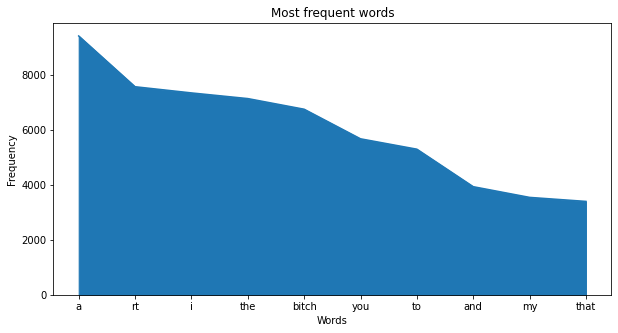

In [9]:
df_uncleaned.plot(kind = "area",
             title = "Most frequent words", 
             legend = False,
             xlabel = "Words",
             ylabel = "Frequency",
             figsize = (10, 5))
plt.xticks(range(0,len(df_uncleaned.index)), df_uncleaned[0])
plt.show()

In [10]:
#tokenizer = Tokenizer(num_words = -1)
#tokenizer.fit_on_texts(df["tweet"])

In [11]:
#word_index = tokenizer.word_index

In [12]:
#print(word_index)

## Remove stopwords

To gain more substantial insight into the data, stopwords such as "i", "a", "at", "the" have to be removed. These words construct the grammatical dependencies of the english language, but do not contain any relevant information to determine hate speech.

## Remove Tags

Twitter tags such as @genericUser do not give further insight for hate speech detection purposes. Thus, they have to be removed.

## Remove Links

Similar to stopwords and Tags, links do not add meaningfull information to the purpose of hate speech --> remove

In [13]:
#Uncomment if nltk stopwords were not downloaded yet
#nltk.download('stopwords')

In [14]:
#Define variable wit henglish stopwords
sw = stopwords.words("english")
twitter_elements = ["rt", "rts", "retweet"]
most_common = word_counts.most_common()



def removeNoise(word_list):
    cleaned_word_list = []
    for element in word_list:
        #Removes words contained in stopwords
        if element[0] not in sw:
            #Removes words with @ --> remove Tags
            if "@" not in element[0]: 
                #Removes words containing http --> links
                if "http" not in element[0]:
                    hasTwitterElement = False
                    for tw in twitter_elements:
                        if tw in element:
                            hasTwitterElement = True
                    if hasTwitterElement == False:
                        cleaned_word_list.append(element)

    return cleaned_word_list

In [15]:
cleaned_word_list_complete = removeNoise(most_common)

In [16]:
df_cleaned_top10 = pd.DataFrame(cleaned_word_list_complete[:10])

In [17]:
df_cleaned_top10

,0,1
0,bitch,6749
1,bitches,2677
2,like,2674
3,hoes,1977
4,pussy,1731
5,i'm,1552
6,hoe,1483
7,ass,1472
8,get,1413
9,fuck,1311


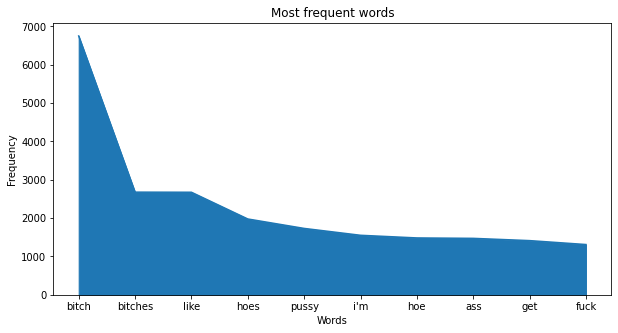

In [18]:
df_cleaned_top10.plot(kind = "area",
             title = "Most frequent words", 
             legend = False,
             xlabel = "Words",
             ylabel = "Frequency",
             figsize = (10, 5))
plt.xticks(range(0,len(df_cleaned_top10.index)), df_cleaned_top10[0])
plt.show()

# Additional Tasks

To further ensure high data quality, we should remove plural words from the pool (e.g. in plot above: bitch/ bitches currently are seperate entities at this point). Furthermore, we should remove twitter specific text such as "rt" for retweet. While words like "i" were removed, words like "i'm" are still present --> remove

In [19]:
cleaned_words_df = tweets.apply(func=removeNoise, axis=1)

In [20]:
cleaned_words_df

0                                                       []
1                                                       []
2                                                       []
3                                                       []
4                                                       []
                               ...                        
24778    [[you's, a, muthaf***in, lie, &#8220;@lifeaski...
24779                                                   []
24780    [[young, buck, wanna, eat!!.., dat, nigguh, li...
24781      [[youu, got, wild, bitches, tellin, you, lies]]
24782    [[~~ruffled, |, ntac, eileen, dahlia, -, beaut...
Length: 24783, dtype: object

In [21]:
tweets

,tweet
0,"[!!!, rt, @mayasolovely:, as, a, woman, you, s..."
1,"[!!!!!, rt, @mleew17:, boy, dats, cold...tyga,..."
2,"[!!!!!!!, rt, @urkindofbrand, dawg!!!!, rt, @8..."
3,"[!!!!!!!!!, rt, @c_g_anderson:, @viva_based, s..."
4,"[!!!!!!!!!!!!!, rt, @shenikaroberts:, the, shi..."
...,...
24778,"[you's, a, muthaf***in, lie, &#8220;@lifeaskin..."
24779,"[you've, gone, and, broke, the, wrong, heart, ..."
24780,"[young, buck, wanna, eat!!.., dat, nigguh, lik..."
24781,"[youu, got, wild, bitches, tellin, you, lies]"
